###  Using the class spectral analysis

Tutorial on how to use the spectral analysis class to compute power spectrum, spectogram, and the pairwise coherence.

In [49]:
%matplotlib inline

import numpy               as np
import matplotlib.pyplot   as plt
from GDa.spectral_analysis import spectral, spectral_analysis
from GDa.session           import session

The class __spectral_analysis__ inherits from a more general class named __spectral__. Let's start by using the __spectral__ class:

In [50]:
spec = spectral()

To use the object __spec__ first we read a sample LFP signal:

In [51]:
data = np.load('raw_lfp/lucy_session01_150304.npy',allow_pickle=True).item()['data']
N    = data.shape[2]   # Number of time points 
fs   = 1000            # Sampling frequency  [Hz]

Next, we will select a random LFP signal in data:

In [52]:
lfp   = data[np.random.randint(0, data.shape[0]),np.random.randint(0, data.shape[1]),:]
# Time axis, using from -0.65 to 3.00 s because this is the event dt we used when we saved the data
time = np.linspace(-0.65, 3.00, lfp.shape[-1]) 

Text(0, 0.5, 'mV')

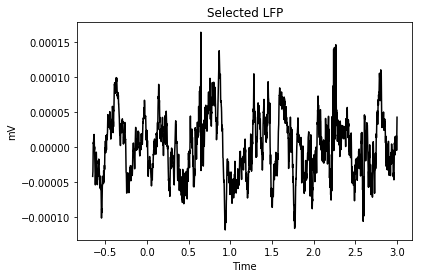

In [53]:
# Plotting the signal
plt.plot(time, lfp, 'k')
plt.title('Selected LFP')
plt.xlabel('Time')
plt.ylabel('mV')

We can bandpass filter the signal with the function __filter__ in __spectral__, let's filter it on the alpha band (8-12 Hz):

In [54]:
lfp_filterd = spec.filter(signal = lfp, fs = fs, f_low = 8, f_high = 12, n_jobs = -1)

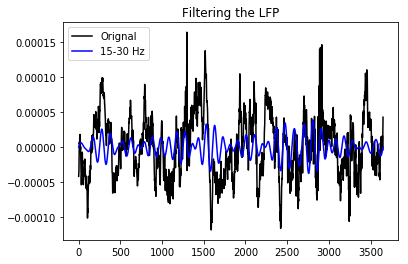

In [55]:
plt.plot(lfp, 'k')
plt.plot(lfp_filterd, 'b')
plt.title('Filtering the LFP')
plt.legend(['Orignal', '15-30 Hz'])

We can compute the spectogram of the signal using the function __spectogram__, it is possible to use morlet or multitaper transforms.



In [56]:
freqs = np.arange(4,30,.1)

W_morlet     = spec.spectogram(signal = lfp[np.newaxis, np.newaxis, :], fs = fs, n_cycles = freqs/2.0,
                               freqs = freqs,
                               method = 'morlet', n_jobs = -1)
W_multitaper = spec.spectogram(signal = lfp[np.newaxis, np.newaxis, :], fs = fs, n_cycles = freqs/2.0,
                               time_bandwidth = 8.0, freqs =freqs, 
                               method = 'multitaper', n_jobs = -1)

ValueError: n_cycles must be a float or an array of length 540 frequencies, got 260 cycles instead.

Next, we can visualize the result:

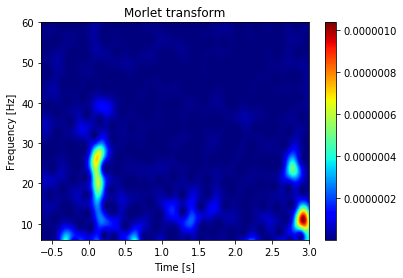

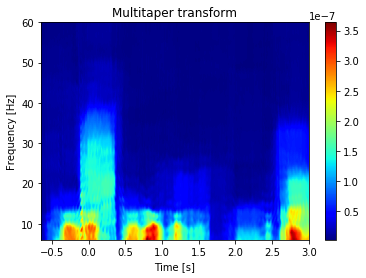

In [35]:
plt.figure()
plt.title('Morlet transform')
plt.imshow(np.squeeze(W_morlet), aspect='auto', cmap='jet', origin='lower', extent=[-0.65, 3.00, 6, 60])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar()
plt.figure()
plt.title('Multitaper transform')
plt.imshow(np.squeeze(W_multitaper), aspect='auto', cmap='jet', origin='lower', extent=[-0.65, 3.00, 6, 60])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar()

We can measure also the instantaneous power with the function __instantaneous_power__, let's see, for instance how the power in alpha band change through time:

In [36]:
P = spec.instantaneous_power(signal = lfp, fs = fs, f_low = 8, f_high = 12, n_jobs = -1)

Text(0, 0.5, 'Power')

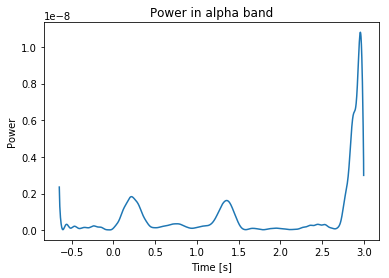

In [37]:
plt.title('Power in alpha band')
plt.plot(time, P)
plt.xlabel('Time [s]')
plt.ylabel('Power')

Finally we can compute the time-frequency coherence between two signals by using the function __coherence__:

In [46]:
coh_morlet = spec.coherence(signal1=data[0,0,:][np.newaxis,np.newaxis,:], 
                            signal2=data[0,1,:][np.newaxis,np.newaxis,:],
                            fs=fs,freqs=freqs,n_cycles=freqs/2.0,
                            method='morlet',n_jobs=-1)
coh_multitaper = spec.coherence(signal1=data[0,0,:][np.newaxis,np.newaxis,:], 
                            signal2=data[0,1,:][np.newaxis,np.newaxis,:],
                            fs=fs,freqs=freqs,n_cycles=freqs/2.0, time_bandwidth=12.0,
                            method='multitaper',n_jobs=-1)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
/home/vinicius/.local/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    2.0s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    2.1s finished


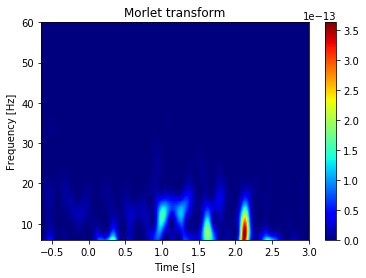

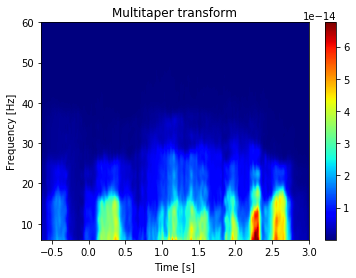

In [47]:
plt.figure()
plt.title('Morlet transform')
plt.imshow(np.squeeze(coh_morlet.real), aspect='auto', cmap='jet', origin='lower', extent=[-0.65, 3.00, 6, 60])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar()
plt.figure()
plt.title('Multitaper transform')
plt.imshow(np.squeeze(coh_multitaper.real), aspect='auto', cmap='jet', origin='lower', extent=[-0.65, 3.00, 6, 60])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar()

For all functions above we can use only one signal as input or for a matrix with dimensions [N_trials, N_channels, time].

The __spectral_analysis__ class inherits the functions from __spectral__ however it is more focused on appling then efficiently to the LFP data. We can instatiate the __spectral_analysis__ class by either passing an session object to it, or by reading the data file saved by the session object (see notebook 1).

In [ ]:
# 1. INSTATIATING SPECTRAL_ANALYSIS USING A SESSION OBJECT

ses = session(raw_path = 'GrayLab/', monkey = 'lucy', stype = 'samplecor', date = '150128', 
              session = 1, evt_dt = [-0.65,3.00])

ses.read_session_info()
ses.read_lfp_data()

spec = spectral_analysis(session = ses, path = None)

In [ ]:
# 2. INSTATIATING SPECTRAL_ANALYSIS USING THE DATA FILE FROM SESSION

spec = spectral_analysis(session = None, path = 'raw_lfp/lucy_session01_150304.npy')

We can do all the operations we did with the __spectral__ object easily now. The operations are done by giving the trial, and channels number in which they should be performed. Let's starting by filtering a random signal in the alpha band.

In [ ]:
lfp_filterd = spec.filter(trial = np.random.randint(0, data.shape[0]), 
                          index_channel = np.random.randint(0, data.shape[1]),
                          apply_to_all = False,
                          f_low = 8, f_high = 12, n_jobs = 1)

Filtering the signal

In [ ]:
plt.plot(time, lfp_filterd )
plt.title('Random LFP filtered in alpha band')
plt.xlabel('Time')
plt.ylabel('mV')

Computing spectogram

In [ ]:
W = spec.spectogram(trial = np.random.randint(0, data.shape[0]), 
                    index_channel = np.random.randint(0, data.shape[1]), 
                    apply_to_all = False,
                    freqs = np.arange(6,60,.01), method = 'morlet', n_jobs = -1)

In [ ]:
plt.imshow(np.squeeze(W), aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[-0.65, 3.00, 6, 60])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')

Instantaneous power spectrum

In [ ]:
P = spec.instantaneous_power(trial = np.random.randint(0, data.shape[0]), 
          index_channel =  np.random.randint(0, data.shape[1]), 
          f_low = 8, f_high = 12, n_jobs = -1)

In [ ]:
plt.plot(time, P)

Computing pairwise coherence, in the function pairwie coherence *fc* is the frenquency center used in the band-pass filter, *df* the width of the filter (i.e., [fc-df, fc+df]), and dt is the length of the convolution window applyied to the instantaneous power spectrum computed.

In [ ]:
coh = spec.pairwise_coherence(trial = 0, 
                              index_pair =  0, step=25,
                              dt = 500, fc = np.arange(6, 62, 1), 
                              df = 4, n_jobs = -1, save_to_file = False)

In [ ]:
plt.imshow(np.real(coh.T), aspect = 'auto', cmap='jet', origin = 'lower', extent = [-0.65, 3.00, 6, 60])

In [ ]:
ch1, ch2 = spec.pairs[0, 0], spec.pairs[0, 1]

In [ ]:
s1, s2 = spec.data[0, ch1,:], spec.data[0, ch2,:]

In [ ]:
plt.plot(time, s1)
plt.plot(time, s2)

In [ ]:
s1f  = spec.filter(trial = 0, index_channel = ch1, f_low = 8, f_high = 12, n_jobs = -1)
s2f  = spec.filter(trial = 0, index_channel = ch2, f_low = 8, f_high = 12, n_jobs = -1)

In [ ]:
plt.plot(time, s1f)
plt.plot(time, s2f)

In [ ]:
import scipy.signal
Sx1 = scipy.signal.hilbert(s1f)
Sy1 = scipy.signal.hilbert(s2f)
Sxy = np.multiply( Sx1, np.conj(Sy1) )
Sxx = np.multiply( Sx1, np.conj(Sx1) )
Syy = np.multiply( Sy1, np.conj(Sy1) )

coh = Sxy*np.conj(Sxy) / (Sxx*Syy)

In [ ]:
plt.plot(time, coh.real)

In [ ]:
import scipy.signal 
f, C = scipy.signal.coherence(s1, s2, fs=1000)

In [ ]:
plt.plot(f, C)

In [ ]:
S = (1+1j)*np.zeros([3, spec.data.shape[2]])
dt = 1000
# Low and high frequency
f_low, f_high = 30, 40
# Channel 1 and 2 indexis
ch1, ch2 = spec.pairs[0, 0], spec.pairs[0, 1]
# Filtering each signal
sig1f  = spec.filter(trial = 0, index_channel = ch1,
                     f_low = f_low, f_high = f_high, n_jobs = -1)
sig2f  = spec.filter(trial = 0, index_channel = ch2, 
                     f_low = f_low, f_high = f_high, n_jobs = -1)
Sx     = scipy.signal.hilbert(sig1f)
Sy     = scipy.signal.hilbert(sig2f)
# Computing instantaneous power spectrum
S[0, :] = np.multiply( Sx, np.conj(Sy) )
S[1, :] = np.multiply( Sx, np.conj(Sx) )
S[2, :] = np.multiply( Sy, np.conj(Sy) )
#Sm = S.T
Sm = scipy.signal.convolve2d(S.T, np.ones([dt, 1]), mode='same')
coh = ( Sm[:, 0]*np.conj(Sm[:, 0]) / (Sm[:, 1]*Sm[:,2]) ).real

In [ ]:
plt.plot(time, coh)

In [ ]:
plt.plot(Sy)
plt.plot(Sy1, '--')

In [ ]:
plt.plot(S[0, :])
plt.plot(S[1, :])
plt.plot(S[2, :])

In [ ]:
Wx = spec.spectogram(trial = 0, 
                    index_channel = 0, 
                    apply_to_all = False,
                    freqs = np.arange(4,30,.1), method = 'multitaper', n_jobs = -1)

Wy = spec.spectogram(trial = 0, 
                    index_channel = 1, 
                    apply_to_all = False,
                    freqs = np.arange(4,30,.1), method = 'multitaper', n_jobs = -1)

coh = (Wx*np.conj(Wy)) * np.conj(Wx*np.conj(Wy)) / (Wx * Wy)

In [ ]:
plt.figure()
plt.imshow(np.squeeze(Wx), aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[-0.65, 3.00, 6, 60])
plt.figure()
plt.imshow(np.squeeze(Wy), aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[-0.65, 3.00, 6, 60])
plt.figure()
plt.imshow(np.squeeze(coh.real), aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[-0.65, 3.00, 6, 60])

In [ ]:
import scipy.signal
Sxy = np.squeeze( np.multiply( Wx, np.conj(Wy) ) )
Sxx = np.squeeze( np.multiply( Wx, np.conj(Wx) ) ) 
Syy = np.squeeze( np.multiply( Wy, np.conj(Wy) ) ) 
Sxym = scipy.signal.convolve2d(Sxy.T, np.ones([500, 1]), mode='same')
Sxxm = scipy.signal.convolve2d(Sxx.T, np.ones([500, 1]), mode='same')
Syym = scipy.signal.convolve2d(Syy.T, np.ones([500, 1]), mode='same')

coh = np.squeeze(Sxym*np.conj(Sxym) / (Sxxm*Syym))

In [ ]:
plt.imshow(np.real(coh.T), aspect = 'auto', cmap='jet', origin = 'lower', extent = [-0.65, 3.00, 6, 60])

In [ ]:
coh.shape

In [ ]:
plt.imshow(np.squeeze(Sxy), aspect = 'auto', cmap='jet', origin = 'lower')

In [ ]:
spec.pairs

In [ ]:
Wx

In [ ]:
import pycwt

In [ ]:
Wxx, _, freqs, _, _, _ = pycwt.cwt(s1, 1.0/1000)
Wyy, _, freqs, _, _, _ = pycwt.cwt(s2, 1.0/1000)
Wxy, _, freqs, _ = pycwt.xwt(s1, s2, 1.0/1000)

In [ ]:
coh = np.multiply( Wxy, np.conj(Wxy) ) / np.multiply(Wxx, Wyy)

In [ ]:
plt.imshow(Wxy.real, aspect = 'auto', cmap='jet', origin = 'lower', extent = [-0.65, 3, freqs[0], freqs[-1]])

In [ ]:
xwt * np.conj(xwt)

In [ ]:
pycwt.xwt?

In [ ]:
Wxy.real.min()


In [ ]:
Sx

In [ ]:
Wx

In [ ]:
Wy

In [21]:
data[0,0,:][np.newaxis,np.newaxis,:].shape

(1, 1, 3651)

In [45]:
np.abs(coh_morlet)

array([[[[2.67483223e-15, 2.78532523e-15, 2.89979776e-15, ...,
          1.02281889e-15, 9.86025496e-16, 9.50091258e-16],
         [2.28528911e-15, 2.38071832e-15, 2.47969832e-15, ...,
          9.59717783e-16, 9.26006445e-16, 8.93032408e-16],
         [1.93821026e-15, 2.02022165e-15, 2.10539671e-15, ...,
          8.98636971e-16, 8.67834925e-16, 8.37659243e-16],
         ...,
         [2.28064894e-17, 2.35173995e-17, 2.42389856e-17, ...,
          7.83805430e-18, 7.61679245e-18, 7.39794377e-18],
         [2.38518587e-17, 2.45999835e-17, 2.53596432e-17, ...,
          7.69457203e-18, 7.47472913e-18, 7.25753663e-18],
         [2.48809182e-17, 2.56666739e-17, 2.64648917e-17, ...,
          7.53781010e-18, 7.32008343e-18, 7.10521188e-18]]]])